In [1]:
import mmcv
import sys
sys.path.append('core')

In [2]:
from builder import build_dataloader, build_dataset

In [3]:
from mmcv import Config
cfg = Config.fromfile("/home/xinyuanyu/work/mmediting/configs/restorers/basicvsr/basicvsr_reds4.py")

In [4]:
test_cfg = cfg.test_cfg

In [5]:
import sr_reds_multiple_gt_dataset
dataset = build_dataset(cfg.data.train)

In [7]:
test = dataset[1]

In [24]:
img1 = test['gt'][0]

In [20]:
img2 = test['lq'][1]

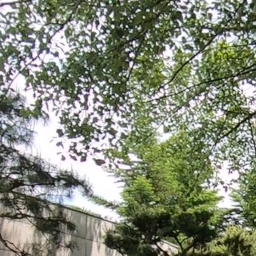

In [25]:
import numpy as np
from PIL import Image
img1 = img1*255
img1 = np.array(img1).transpose(1, 2, 0).astype(np.uint8)
Image.fromarray(img1)

In [22]:
img1

tensor([[[0.8078, 0.7725, 0.7176,  ..., 0.3843, 0.7569, 0.2627],
         [0.6000, 0.8235, 0.6667,  ..., 0.5608, 0.3569, 0.2235],
         [0.9569, 0.9961, 0.9373,  ..., 0.4745, 0.5098, 0.3804],
         ...,
         [0.5255, 0.4039, 0.6000,  ..., 0.2510, 0.2706, 0.5882],
         [0.4745, 0.5373, 0.4588,  ..., 0.1804, 0.2902, 0.5255],
         [0.5333, 0.6078, 0.6510,  ..., 0.1686, 0.2824, 0.4157]],

        [[0.7882, 0.7412, 0.7059,  ..., 0.3882, 0.7882, 0.2980],
         [0.5333, 0.7647, 0.6471,  ..., 0.5882, 0.4078, 0.2588],
         [0.9255, 0.9922, 0.9294,  ..., 0.5176, 0.5647, 0.4235],
         ...,
         [0.5020, 0.3608, 0.5333,  ..., 0.2706, 0.2863, 0.5961],
         [0.4510, 0.4980, 0.4078,  ..., 0.1922, 0.3059, 0.5529],
         [0.5020, 0.5647, 0.6078,  ..., 0.1804, 0.2902, 0.4196]],

        [[0.8118, 0.7961, 0.7373,  ..., 0.3922, 0.7922, 0.2118],
         [0.6510, 0.8549, 0.7059,  ..., 0.5765, 0.3804, 0.1843],
         [0.9765, 0.9922, 0.9373,  ..., 0.4784, 0.5059, 0.

In [16]:
img1 = test['lq'][0]
img1.shape

torch.Size([3, 64, 64])

In [9]:
import numpy as np
from core.utils import frame_utils 
from PIL import Image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

In [10]:
DEVICE = 'cuda'
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--path', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args = parser.parse_args(args=['--model', 'models/raft-things.pth', '--path', 'demo-frames'])

In [11]:
try:
    autocast = torch.cuda.amp.autocast
except:
    # dummy autocast for PyTorch < 1.6
    class autocast:
        def __init__(self, enabled):
            pass
        def __enter__(self):
            pass
        def __exit__(self, *args):
            pass
        
model = torch.nn.DataParallel(RAFT(args))
model = model.module
model.to(DEVICE)
model.eval()
with torch.no_grad():
    img1 = img1[None, ...]
    img2 = img2[None, ...]
    img1 = img1.cuda()
    img2 = img2.cuda()
    img1 = img1.contiguous()
    img2 = img2.contiguous()
    hdim = model.hidden_dim
    cdim = model.context_dim
    with autocast(enabled=model.args.mixed_precision):
        fmap1 = model.fnet(img1)
        fmap2 = model.fnet(img2)
    fmap1 = fmap1.float()
    fmap2 = fmap2.float()

In [12]:
model.args.alternate_corr

False

In [13]:
model.args.corr_radius

4

In [14]:
fmap1.shape

torch.Size([1, 128, 64, 64])

In [15]:
from corr import CorrBlock, AlternateCorrBlock
corr_fn = CorrBlock(fmap1, fmap2, radius=model.args.corr_radius)

In [16]:
pyramid = corr_fn.corr_pyramid

In [17]:
len(pyramid)

4

In [18]:
with autocast(enabled=model.args.mixed_precision):
    cnet = model.cnet(img1)
    net, inp = torch.split(cnet, [hdim, cdim], dim=1)
    net = torch.tanh(net)
    inp = torch.relu(inp)

In [19]:
coords0, coords1 = model.initialize_flow(img1)

In [20]:
coords1 = coords1.detach()

In [21]:
corr = corr_fn(coords1)

In [22]:
flow = coords1 - coords0

In [23]:
flow.shape

torch.Size([1, 2, 64, 64])

In [24]:
with autocast(enabled=model.args.mixed_precision):
    net, up_mask, delta_flow = model.update_block(net, inp, corr, flow)

In [25]:
corr = corr_fn(coords1)

In [26]:
coords1 = coords1 + delta_flow

In [27]:
# net is the hidden state
# inp is the regularization term
# corr is the correlation volume
# flow 

# net
# up_mask
# delta_flow

corr.shape

torch.Size([1, 324, 64, 64])

In [28]:
flow.shape

torch.Size([1, 2, 64, 64])

In [30]:
basicUpdate = model.update_block

In [31]:
basicUpdate.encoder

BasicMotionEncoder(
  (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
  (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [34]:
import torch.nn.functional as F
basicMotion = basicUpdate.encoder
cor = F.relu(basicMotion.convc1(corr))

In [38]:
motion_features = basicMotion(flow, corr)
inp = torch.cat([inp, motion_features], dim=1)

In [39]:
inp.shape

torch.Size([1, 256, 64, 64])

In [6]:
for i_batch, data_blob in enumerate(dataset):
    import pdb
    pdb.set_trace()
    print(i_batch)

> <ipython-input-6-4b11a9fc7c70>(4)<module>()
      1 for i_batch, data_blob in enumerate(dataset):
      2     import pdb
      3     pdb.set_trace()
----> 4     print(i_batch)

ipdb> i_batch
0
ipdb> data_blob
{'meta': DataContainer({'lq_path': ['/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000011.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000012.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000013.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000014.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000015.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000016.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000017.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000018.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000019.png', '/home/xinyuanyu/data/REDS/train/train_sharp_bicubic/X4/001/00000020.png', '/h

ipdb> lq_blob = data_blob['lq']
ipdb> lq_blob.shape
torch.Size([15, 3, 64, 64])
ipdb> gt_blob = data_blob['qt']
*** KeyError: 'qt'
ipdb> gt_blob = data_blob['gt']
ipdb> gt_blob.shape
torch.Size([15, 3, 256, 256])
ipdb> exit()


BdbQuit: 

In [ ]:
for i_batch, data_blob in enumerate(dataset):
    import pdb
    pdb.set_trace()
    img1 = data_blob['lq'][0]
    img2 = data_blob['lq'][1]
    gt = data_blob['gt'][1]
    

> <ipython-input-26-928afcac5d4a>(4)<module>()
      2     import pdb
      3     pdb.set_trace()
----> 4     img1 = data_blob['lq'][0]
      5     img2 = data_blob['lq'][1]
      6     gt = data_blob['gt'][1]

ipdb> test = [x.cuda() for x in data_blob]
*** AttributeError: 'str' object has no attribute 'cuda'
ipdb> test = [x for x in data_blob]
ipdb> test
['meta', 'lq', 'gt']
ipdb> data_blob['lq'].shape
torch.Size([15, 3, 64, 64])
ipdb> data_blob['gt'].shape
torch.Size([15, 3, 256, 256])
